In [1]:
import json
from preprocessor.preprocessor_pytorch import Preprocessor
from model.model_pytorch import Model
from postprocessor.postprocessor import Postprocesser
from evaluator.evaluator_pytorch import Evaluator
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
    torch.manual_seed(seed_value)
set_seed(42)

with open('parameters.json', 'r') as file:
    params = json.load(file)

In [2]:
preprocessor = Preprocessor()
data = preprocessor.fetch_stock_data(params['stock_symbol'], params['start_date'], params['stop_date'])
for single_feature_params in params['features_params']:
    feature_type = single_feature_params["type"]
    data = preprocessor.add_feature(data, feature_type, **single_feature_params)
data, issues_detected = preprocessor.add_data_cleaner(data, 
    clean_type=params['data_cleaning']['clean_type'], strategy=params['data_cleaning']['strategy'])
X_train, y_train, X_test, y_test, train_dates, test_dates = \
    preprocessor.process_data(data, split_ratio=params['split_ratio'], target_col=params['target_col'], 
                            feature_cols=None, look_back=params['look_back'],
                            predict_steps=params['predict_steps'], 
                            train_slide_steps=params['train_slide_steps'], 
                            test_slide_steps=params['test_slide_steps'],
                            reshape=params['model_params'][params['model_type']]['reshape'])
X_newest, x_newest_date = preprocessor.create_x_newest_data(data, params['look_back'])


[*********************100%***********************]  1 of 1 completed


c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0112\project\preprocessor\preprocessor_pytorch.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0 # up trend
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0112\project\preprocessor\preprocessor_pytorch.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1 # down trend


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([3430, 19, 64]),
 torch.Size([3430, 2, 16]),
 torch.Size([90, 19, 64]),
 torch.Size([90, 2, 16]))

In [4]:
# X_train = torch.transpose(X_train, 1, 2)
# X_test = torch.transpose(X_test, 1, 2)
# X_newest = torch.transpose(X_newest, 1, 2)
# y_train = torch.transpose(y_train, 1, 2)
# y_test = torch.transpose(y_test, 1, 2)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([3430, 19, 64]),
 torch.Size([3430, 2, 16]),
 torch.Size([90, 19, 64]),
 torch.Size([90, 2, 16]))

In [6]:
params = {
    "start_date": "2001-01-01",
    "stop_date": "2021-01-01",
    "stock_symbol": "^GSPC",
    "features_params": [
        {"type": "Trend", "method": "MA", "oder_days": 20,
         "ma_days": 20, "trend_days": 5},
        {"type": "MACD", "fastperiod": 5, "slowperiod": 10, "signalperiod": 9},
        {"type": "ROC", "trend_days": 5},
        {"type": "Stochastic Oscillator", "trend_days": 5},
        {"type": "CCI", "timeperiod": 14},
        {"type": "RSI", "timeperiod": 14},
        {"type": "VMA", "timeperiod": 20},
        {"type": "PctChange"},
        {"type": "3M Treasury Yield", "start_date": "2001-01-01",
            "end_date": "2021-01-01"},
        {"type": "5Y Treasury Yield", "start_date": "2001-01-01",
            "end_date": "2021-01-01"},
        {"type": "10Y Treasury Yield",
            "start_date": "2001-01-01", "end_date": "2021-01-01"},
        {"type": "30Y Treasury Yield",
            "start_date": "2001-01-01", "end_date": "2021-01-01"}
    ],
    "data_cleaning": {
        "clean_type": "MissingData", 
        "strategy": "auto"
    },
    "split_ratio": 0.7,
    "target_col": "Trend",
    "feature_cols": [
        "MACD", "ROC", "CCI", "RSI", "VMA", 
        "3M Treasury Yield", "5Y Treasury Yield",
        "10Y Treasury Yield", "30Y Treasury Yield"
    ],
    "look_back": 64,
    "predict_steps": 16,
    "train_slide_steps": 1,
    "test_slide_steps": 16,
    "model_params": {
        "LeNet": {
            "look_back": 64,
            "predict_steps": 16,
            "conv_1_in_channels": 19,
            "conv_1_out_channels": 16,
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool2d_1_kernel_size": 2,
            "fc_1_out_features": 512,
            "reshape": "True"
        },
        "LeNet_2": {
            "look_back": 64,
            "predict_steps": 16,
            "conv_1_in_channels": 19,
            "conv_1_out_channels": 6,
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool2d_1_kernel_size": 2,
            "conv_2_out_channels": 16,
            "conv_2_kernel": 3,
            "conv_2_padding": 1,
            "MaxPool2d_2_kernel_size": 2,
            "fc_1_out_features": 512,
            "reshape": "True"
        },
        "RNN": {
            "look_back": 64,
            "predict_steps": 16,
            "hidden_size": 64,
            "num_layers": 1,
            "dropout": 0.2,
            "reshape": "False"
        },
        "LSTM": {
            "look_back": 64,
            "predict_steps": 16,
            "hidden_size": 64,
            "num_layers": 1,
            "dropout": 0.2,
            "reshape": "False"
        },
        "CNN_LSTM": {
            "look_back": 64,
            "predict_steps": 16,
            "conv_1_in_channels": 19,
            "conv_1_out_channels": 6,
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool2d_1_kernel_size": 2,
            "conv_2_out_channels": 16,
            "conv_2_kernel": 3,
            "conv_2_padding": 1,
            "MaxPool2d_2_kernel_size": 2,
            "fc_1_out_features": 512,
            "hidden_size": 64,
            "num_layers": 1,
            "dropout": 0.2,
            "reshape": "True"
        }
    },
    "model_type" : "CNN_LSTM",
    "training_epoch_num": 1000,
    "online_training_epoch_num": 10,
    "learning_rate": 0.001
  }
  

In [7]:
# class ModelCNN_LSTM(nn.Module):
#     def __init__(self, params=dict(), input_shape=tuple()):
#         super(ModelCNN_LSTM, self).__init__()
#         self.params = params

#         # Convolution layers
#         self.conv1 = nn.Conv1d(input_shape[1],
#                                self.params["model_params"]["CNN_LSTM"]["conv_1_out_channels"],
#                                kernel_size=self.params["model_params"]["CNN_LSTM"]["conv_1_kernel"],
#                                padding=self.params["model_params"]["CNN_LSTM"]["conv_1_padding"])
#         self.conv2 = nn.Conv1d(self.params["model_params"]["CNN_LSTM"]["conv_1_out_channels"],
#                                self.params["model_params"]["CNN_LSTM"]["conv_2_out_channels"],
#                                kernel_size=self.params["model_params"]["CNN_LSTM"]["conv_2_kernel"],
#                                padding=self.params["model_params"]["CNN_LSTM"]["conv_2_padding"])

#         # Calculate size after convolutions and pooling
#         self._to_linear = None
#         self.convs = nn.Sequential(
#             self.conv1,
#             nn.LayerNorm([self.params["model_params"]["CNN_LSTM"]["conv_1_out_channels"],
#                           self.params["look_back"]]),
#             nn.ReLU(),
#             nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool2d_1_kernel_size"]),
#             self.conv2,
#             nn.LayerNorm([self.params["model_params"]["CNN_LSTM"]["conv_2_out_channels"],
#                           int(self.params["look_back"]/self.params["model_params"]["CNN_LSTM"]["MaxPool2d_2_kernel_size"])]),
#             nn.ReLU(),
#             nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool2d_2_kernel_size"])
#         )
#         self._get_conv_output((1, input_shape[1], self.params["look_back"]))

#         # Fully connected layers
#         self.fc1 = nn.Linear(self._to_linear, self.params["model_params"]["CNN_LSTM"]["fc_1_out_features"])
#         self.ln1 = nn.LayerNorm(self.params["model_params"]["CNN_LSTM"]["fc_1_out_features"])
#         self.fc2 = nn.Linear(self.params["model_params"]["CNN_LSTM"]["fc_1_out_features"],
#                              self.params["model_params"]["CNN_LSTM"]["predict_steps"] * 2)

#     def _get_conv_output(self, shape):
#         with torch.no_grad():
#             input = torch.rand(*shape)
#             output = self.convs(input)
#             self._to_linear = int(torch.flatten(output, 1).shape[1])

#     def forward(self, x):
#         x = x.view(-1, x.shape[-2], x.shape[-1])  # Reshape to match the input format
#         x = self.convs(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = self.ln1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = x.view(-1, 2, self.params["model_params"]["CNN_LSTM"]["predict_steps"])  # Reshape to the desired output shape
#         return x

In [8]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train(model, X_train, y_train):
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopper = EarlyStopper(patience=3, min_delta=10)

    train_losses = []
    train_accuracy = []

    num_epochs = 1000
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_train)
        loss = loss_function(outputs, y_train)

        # backward pass and update weights
        loss.backward()
        optimizer.step()

        # calculate accuracy
        _, predicted = torch.max(outputs.data, -1)
        correct = (predicted == y_train.argmax(dim=-1)).sum().item()
        accuracy = correct / (y_train.size(-3)*y_train.size(-2))
        train_losses.append(loss.item())
        train_accuracy.append(accuracy)

        # early stopping based on training loss
        if early_stopper.early_stop(loss.item()):             
            break

    history = {
        'loss': train_losses,
        'binary_accuracy': train_accuracy
    }
    return history


def infer(model, X_test):
    y_pred = model(X_test)
    return y_pred

In [9]:
def online_train(model, X_train, y_train, single_X_test, 
                    single_y_test, data_update_mode='newest'):
    # Update the training dataset with the new instance
    if data_update_mode == 'append':
        online_X_train = torch.cat((X_train, single_X_test), dim=0)
        online_y_train = torch.cat((y_train, single_y_test), dim=0)
    elif data_update_mode == 'replace':
        online_X_train = torch.cat((X_train[1:], single_X_test), dim=0)
        online_y_train = torch.cat((y_train[1:], single_y_test), dim=0)
    elif data_update_mode == 'newest':
        online_X_train = single_X_test
        online_y_train = single_y_test
    else:
        raise ValueError(f"Invalid data update mode: {data_update_mode}")

    # Add the instance and its actual result to the training dataset
    X_train = np.append(X_train, single_X_test, axis=0)
    y_train = np.append(y_train, single_y_test, axis=0)

    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10
    history = {}
    for epoch in range(num_epochs):
        # Retrain the model on this updated dataset
        model.train()
        optimizer.zero_grad()

        # forward pass
        outputs = model(online_X_train)
        loss = loss_function(outputs, online_y_train)
        _, predicted = torch.max(outputs.data, -1)
        correct = (predicted == online_y_train.argmax(dim=-1)).sum().item()
        accuracy = correct / online_y_train.size(-2)
        # backward pass and update weights
        loss.backward()
        optimizer.step()
    history = {
        'loss': loss.item() / online_y_train.size(-2),
        'binary_accuracy': accuracy
        }
    return history

In [10]:
class ModelCNN_LSTM(nn.Module):
    def __init__(self, params, input_shape):
        super(ModelCNN_LSTM, self).__init__()

        # Convolution layers
        self.conv1 = nn.Conv1d(19, 6, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(6, 16, kernel_size=3, padding=1)

        # Calculate size after convolutions and pooling
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            nn.LayerNorm([6, 64]),
            nn.ReLU(),
            nn.MaxPool1d(2),
            self.conv2,
            nn.LayerNorm([16, int(64/2)]),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self._get_conv_output((1, input_shape[1], 64))
        
        self.lstm = nn.LSTM(input_size=16,
                    hidden_size=64,
                    num_layers=1,
                    dropout=0.2,
                    batch_first=True)
        
        # Fully connected layers
        self.fc = nn.Linear(64, 2)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(*shape)
            output = self.convs(input)
            self._to_linear = int(torch.flatten(output, 1).shape[1])
            
    def init_hidden(self, batch_size):
        # Initialize the hidden state and cell state
        hidden_state = torch.zeros(1, batch_size, 64)
        cell_state = torch.zeros(1, batch_size, 64)
        return (hidden_state, cell_state)
    
    def forward(self, x):
        x = x.view(-1, x.shape[-2], x.shape[-1])  # Reshape to match the input format
        x = self.convs(x)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        
        # Reshape output for the fully connected layer
        output = output.contiguous().view(-1, 64)
        output = self.fc(output)
        output = torch.sigmoid(output)
        
        # Reshape back to [batch_size, sequence_length, output_size]
        output = output.view(batch_size, 2, -1)

        # Ensure the output shape matches the target shape, [batch_size, 2, 16]
        # Adjust this slicing as needed based on your specific requirements
        output = output[:, -16:, :]  # Adjust this to match the target shape
        return output


In [11]:
# Create a new model if no pre-trained model is provided
model = ModelCNN_LSTM(params=params, input_shape=X_train.shape)
# Train the new model
history = train(model, X_train, y_train)


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


In [12]:
online_training_losses = []
online_training_acc = []
y_preds = []
for i in tqdm.tqdm(range(len(X_test))):
    # Predict the next instance
    y_pred = infer(model, X_test[i:i+1])
    y_preds.append(y_pred[0])

    # Perform online training
    online_history = online_train(
        model, X_train, y_train, X_test[i:i+1], y_test[i:i+1], data_update_mode='append')
    # for epoch in online_history:
    online_training_losses.append(online_history['loss'])
    online_training_acc.append(
        online_history['binary_accuracy'])
y_preds = torch.stack(y_preds).detach().numpy()

100%|██████████| 90/90 [05:06<00:00,  3.41s/it]


In [13]:
# model_wrapper = Model()
# model, history, y_preds, online_training_losses, online_training_acc = \
#     model_wrapper.run(params['model_type'], params['look_back'], params['model_params']['LeNet'],
#                         X_train, y_train, X_test, y_test)


In [14]:
y_test.shape, y_preds.shape

(torch.Size([90, 2, 16]), (90, 2, 16))

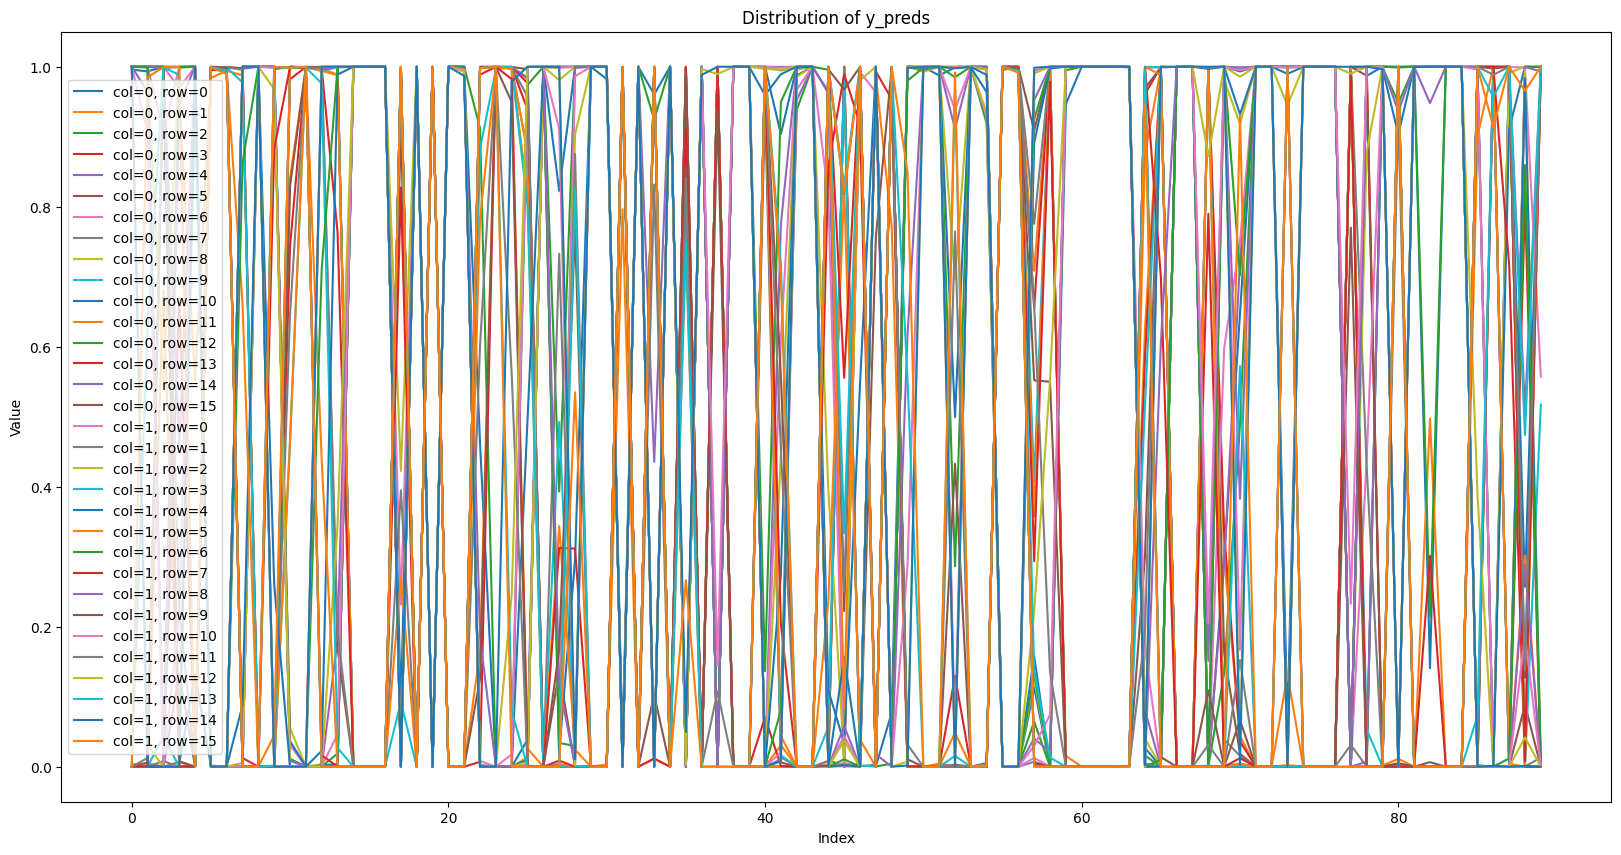

In [15]:
import matplotlib.pyplot as plt

# Plot the distribution of each column in y_preds
plt.figure(figsize=(20, 10))
for col in range(y_preds.shape[1]):
    for row in range(y_preds.shape[2]):
        plt.plot(y_preds[:, col, row], label=f'col={col}, row={row}')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Distribution of y_preds')
plt.legend()
plt.show()


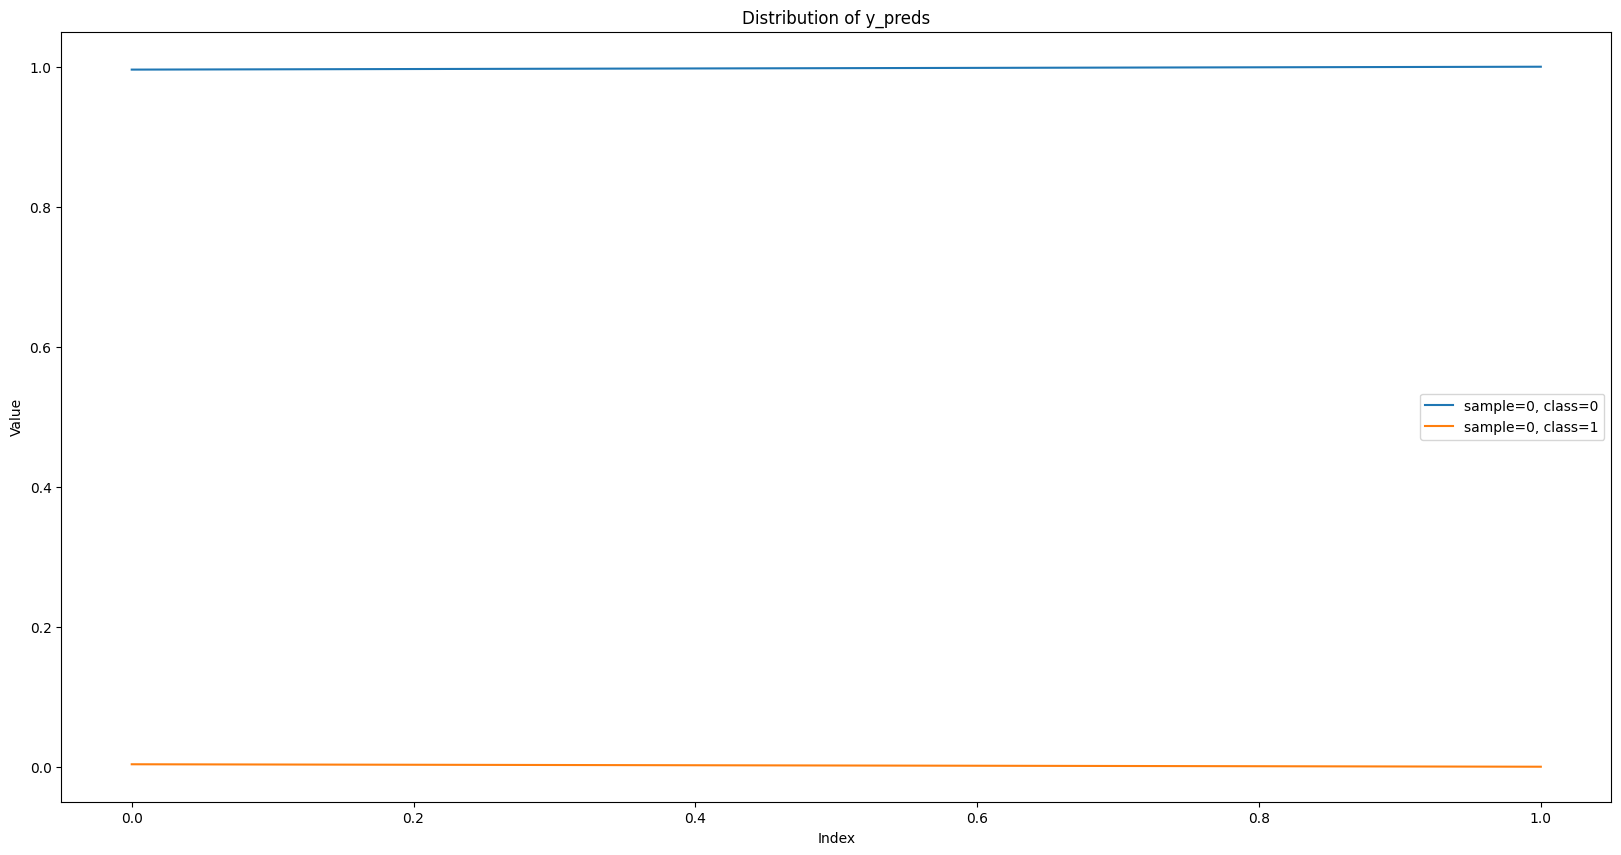

In [16]:
import matplotlib.pyplot as plt

# Plot the distribution of each column in y_preds
plt.figure(figsize=(20, 10))
# for col in range(y_preds.shape[0]):
#     for row in range(y_preds.shape[2]):
for col in range(1):
    for row in range(2):
        plt.plot(y_preds[col, :, row], label=f'sample={col}, class={row}')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Distribution of y_preds')
plt.legend()
plt.show()


In [17]:
import numpy as np
import pandas as pd

class Postprocesser:
    def __init__(self):
        pass
    
    def check_shape(self, X_train, X_test, X_newest, y_train, y_test, y_preds, reshape="False"):
        if reshape == "True":
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])
            X_newest = X_newest.reshape(X_newest.shape[0], X_newest.shape[2], X_newest.shape[1])
            y_train = y_train.reshape(y_train.shape[0], y_train.shape[2], y_train.shape[1])
            y_test = y_test.reshape(y_test.shape[0], y_test.shape[2], y_test.shape[1])
            y_preds = y_preds.reshape(y_preds.shape[0], y_preds.shape[2], y_preds.shape[1])
        return X_train, X_test, X_newest, y_train, y_test, y_preds
    
    def modify_rows(self, arr):
        for row in arr:
            # Find the first index in the row where the change occurs
            change_index = np.where(np.diff(row) != 0)[0]
            if change_index.size > 0:
                first_change_index = change_index[0] + 1
                # Set all values after the first change to the value at the change index
                row[first_change_index:] = row[first_change_index]
        return arr

    def remove_short_sequences(self, arr, x):
        """
        Remove sequences in the array that are shorter than x, considering both 0 to 1 and 1 to 0 changes.

        :param arr: The input array
        :param x: The minimum sequence length to keep
        :return: The modified array
        """
        # Identify the changes in the array
        change_indices = np.where(np.diff(arr) != 0)[0] + 1
        # Include the start and end of the array
        change_indices = np.insert(change_indices, 0, 0)
        change_indices = np.append(change_indices, len(arr))
        
        for i in range(len(change_indices) - 1):
            # Calculate the length of the sequence
            seq_length = change_indices[i+1] - change_indices[i]
            if seq_length < x:
                # Set the values of short sequences to the value preceding the sequence
                arr[change_indices[i]:change_indices[i+1]] = arr[change_indices[i] - 1]
        return arr

    def process_signals(self, y_data, dates, filter):
        max_indices = np.argmax(y_data, axis=-1)
        # max_indices = self.modify_rows(max_indices)
        flatten_max_indices = max_indices.flatten()
        if filter:
            flatten_max_indices = self.remove_short_sequences(flatten_max_indices.copy(), filter)
        signals = np.full(flatten_max_indices.shape, '', dtype=object)

        for i in range(1, len(flatten_max_indices)):
            # downward to upward
            if flatten_max_indices[i-1] == 1 and flatten_max_indices[i] == 0:
                signals[i] = 'Buy'
            # upward to downward
            elif flatten_max_indices[i-1] == 0 and flatten_max_indices[i] == 1:
                signals[i] = 'Sell'

        non_empty_signals = np.where(signals != '')[0]
        if non_empty_signals.size > 0:
            first_signal_index = non_empty_signals[0]
            last_signal_index = non_empty_signals[-1]
            signals[first_signal_index] += ' (first)'
            signals[last_signal_index] += ' (last)'

        flat_dates = dates.flatten()
        return pd.DataFrame({'Date': flat_dates, 'Signal': signals})


In [18]:
y_preds.shape

(90, 2, 16)

In [19]:
postprocessor = Postprocesser()

X_train, X_test, X_newest, y_train, y_test, y_preds = \
    postprocessor.check_shape(X_train, X_test, X_newest, y_train, y_test, y_preds, reshape=params['model_params'][params['model_type']]['reshape'])
test_trade_signals = postprocessor.process_signals(y_test, test_dates, False)
pred_trade_signals = postprocessor.process_signals(y_preds, test_dates, 20)


In [20]:
pred_trade_signals

,Date,Signal
0,2015-04-16,
1,2015-04-17,
2,2015-04-20,
3,2015-04-21,
4,2015-04-22,
...,...,...
1435,2020-12-24,
1436,2020-12-28,
1437,2020-12-29,
1438,2020-12-30,


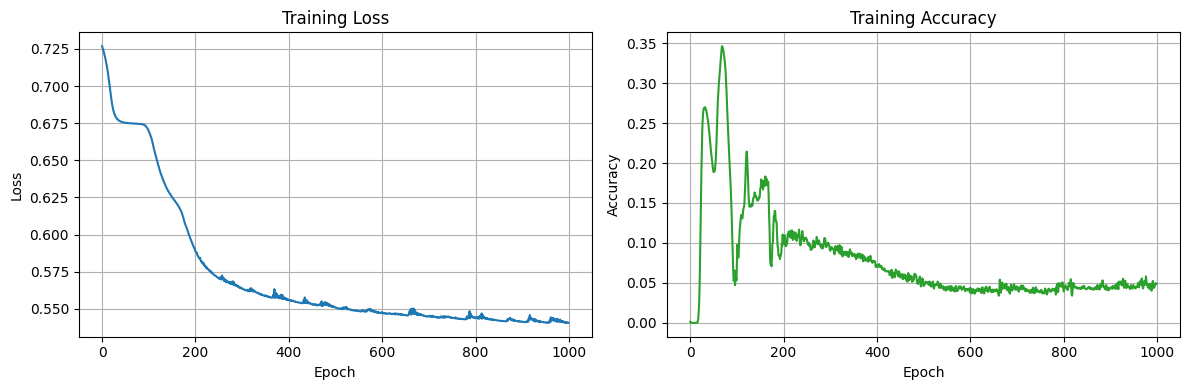

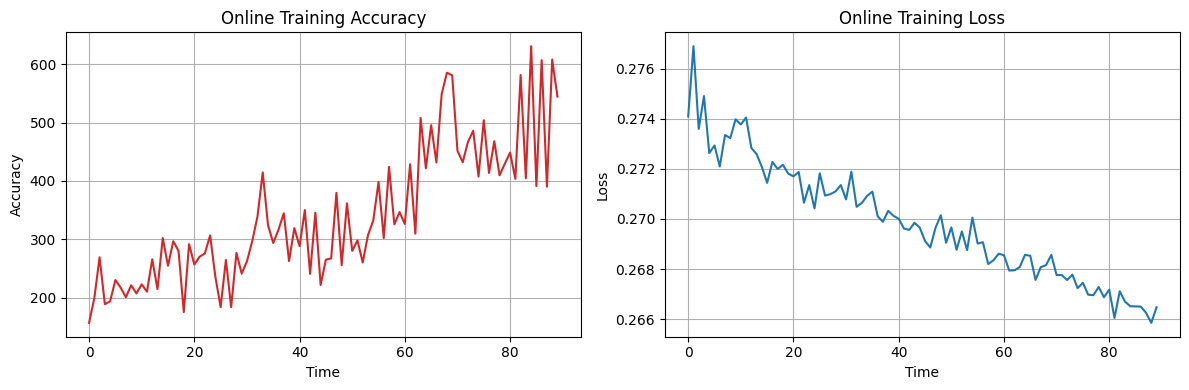

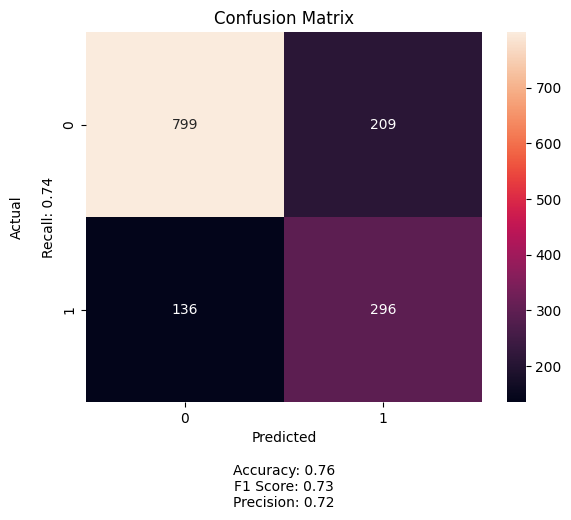

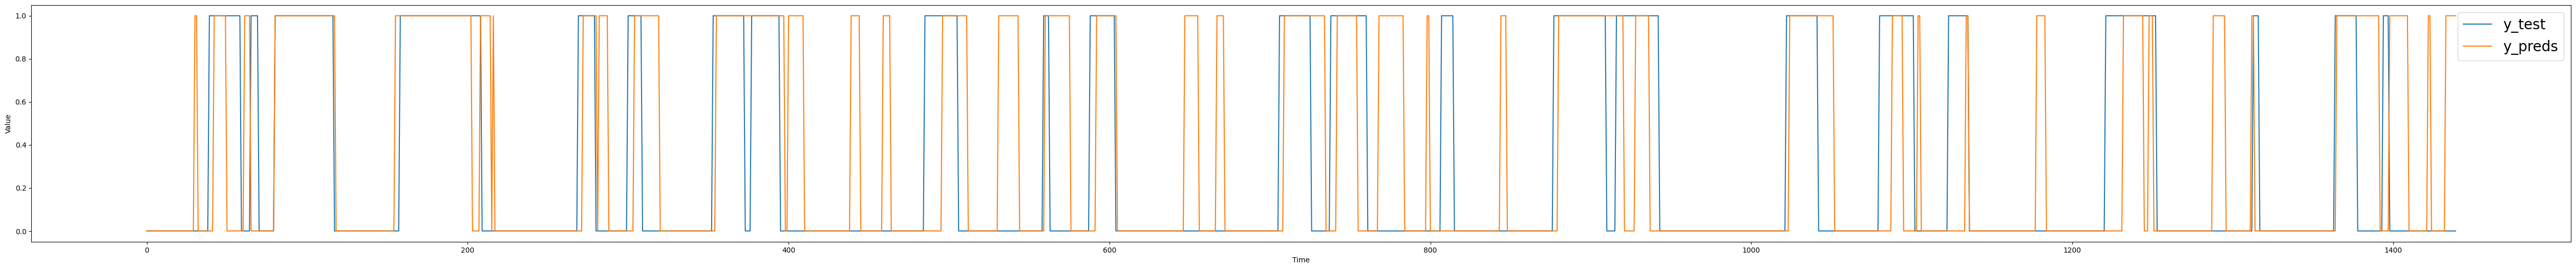

c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0112\project\evaluator\evaluator_pytorch.py:168: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Buy') | (trade_signals['Signal'] == 'Buy (first)')]
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0112\project\evaluator\evaluator_pytorch.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sell_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Sell') | (trade_signals['Signal'] == 'Sell (first)')]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


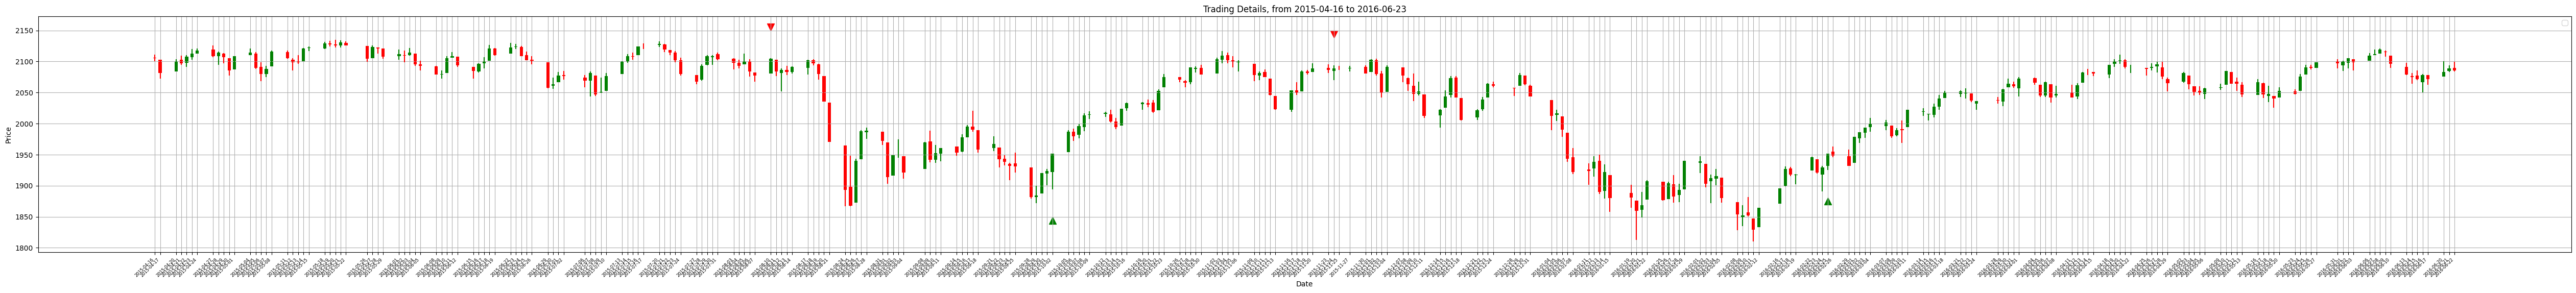

c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0112\project\evaluator\evaluator_pytorch.py:168: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Buy') | (trade_signals['Signal'] == 'Buy (first)')]
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0112\project\evaluator\evaluator_pytorch.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sell_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Sell') | (trade_signals['Signal'] == 'Sell (first)')]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


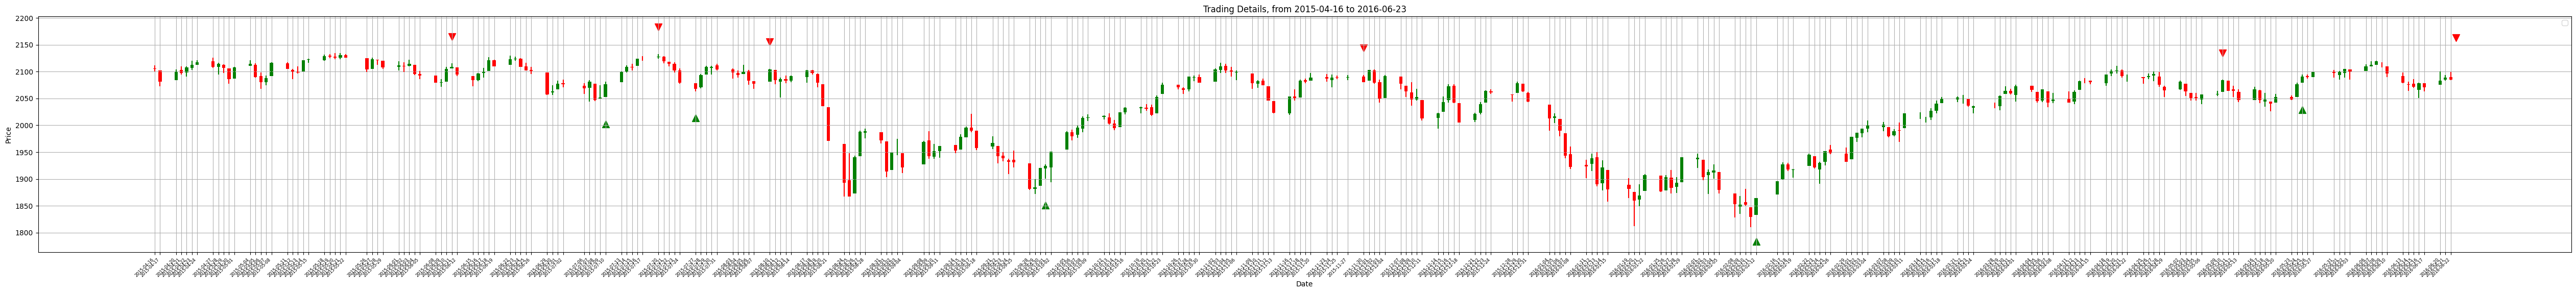

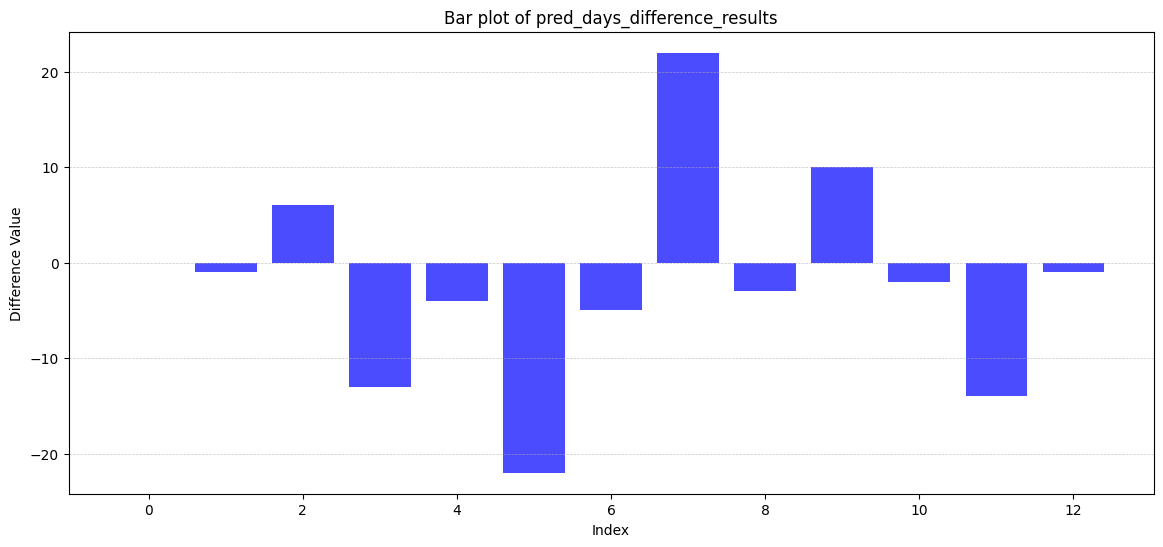

In [22]:
evaluator = Evaluator()
total = sum([param.nelement() for param in model.parameters()])
model_summary = f'{model}, \nNumber of parameter: {total}'
print(model_summary)
evaluator.generate_report(model, y_test, y_preds, history, 
                        online_training_acc, online_training_losses,
                        data, pred_trade_signals, test_trade_signals, x_start=0, x_stop=300)
